In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from datetime import datetime
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import seaborn as sns
import warnings
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)


In [23]:
# -------------------------------
# 1. Load Data
# -------------------------------
# CSV should have columns: Date, Price
df = pd.read_csv("Downloads/Nat_Gas.csv")

df.head()

,Dates,Prices
0,10/31/20,10.1
1,11/30/20,10.3
2,12/31/20,11.0
3,1/31/21,10.9
4,2/28/21,10.9


In [3]:
sns.set_style("whitegrid")

In [4]:
price_col = df.columns[-1]   # Automatically take last column as price
prices = df[price_col]


In [5]:
# -------------------------------
# 2.INPUT PARAMETERS
# -------------------------------

quantity = 1_000_000  # MMBtu

buy_price = 2.0       # $ per MMBtu (Summer)
sell_price = 3.0      # $ per MMBtu (Winter)

storage_months = 4
storage_cost_per_month = 100_000

injection_withdrawal_cost = 10_000
transport_cost_per_trip = 50_000  # one way
transport_total_cost = transport_cost_per_trip * 2  # to & from

In [6]:
# -------------------------------
# 3.CALCULATIONS
# -------------------------------

gross_profit = (sell_price - buy_price) * quantity
storage_cost_total = storage_months * storage_cost_per_month
total_costs = storage_cost_total + injection_withdrawal_cost + transport_total_cost
net_contract_value = gross_profit - total_costs

In [7]:
# -------------------------------
# 4.PRINT RESULTS
# -------------------------------

print("===== Natural Gas Contract Valuation =====")
print(f"Gross Profit: ${gross_profit:,.0f}")
print(f"Total Storage Cost: ${storage_cost_total:,.0f}")
print(f"Injection/Withdrawal Cost: ${injection_withdrawal_cost:,.0f}")
print(f"Transport Cost: ${transport_total_cost:,.0f}")
print(f"-------------------------------------------")
print(f"Net Contract Value: ${net_contract_value:,.0f}")


===== Natural Gas Contract Valuation =====
Gross Profit: $1,000,000
Total Storage Cost: $400,000
Injection/Withdrawal Cost: $10,000
Transport Cost: $100,000
-------------------------------------------
Net Contract Value: $490,000


In [8]:
# ------------------------------------------------------------
# 5. CALCULATE RETURNS FOR SIMULATION
# ------------------------------------------------------------

returns = prices.pct_change().dropna()
mu = returns.mean()
sigma = returns.std()

current_price = prices.iloc[-1]


In [9]:
# -----------------------------------------------------------
# 6. MONTE CARLO SIMULATION
# ------------------------------------------------------------

simulations = 10000
months = 4
quantity = 1_000_000

buy_price = current_price

# Generate random future winter prices
simulated_prices = []

for _ in range(simulations):
    price = buy_price
    for _ in range(months):
        shock = np.random.normal(mu, sigma)
        price = price * (1 + shock)
    simulated_prices.append(price)

simulated_prices = np.array(simulated_prices)


In [10]:
# -------------------------------
# 7. DATAFRAME FOR VISUALIZATION
# -------------------------------

data = pd.DataFrame({
    "Component": [
        "Gross Profit",
        "Storage Cost",
        "Injection/Withdrawal",
        "Transport Cost",
        "Net Value"
    ],
    "Amount": [
        gross_profit,
        -storage_cost_total,
        -injection_withdrawal_cost,
        -transport_total_cost,
        net_contract_value
    ]
})

In [11]:
# -------------------------------
# 8. COLOR MAPPING (High = Green, Low = Red)
# -------------------------------

norm = plt.Normalize(data["Amount"].min(), data["Amount"].max())
colors = plt.cm.RdYlGn(norm(data["Amount"]))


In [12]:
# ------------------------------------------------------------
# 9. COST STRUCTURE
# ------------------------------------------------------------

storage_cost_per_month = 100_000
storage_total = storage_cost_per_month * months

injection_withdrawal_cost = 10_000
transport_cost = 50_000 * 2

total_costs = storage_total + injection_withdrawal_cost + transport_cost



In [13]:
# ------------------------------------------------------------
# 10. CONTRACT VALUES
# ------------------------------------------------------------

gross_profits = (simulated_prices - buy_price) * quantity
net_values = gross_profits - total_costs

expected_sell_price = simulated_prices.mean()
expected_gross_profit = gross_profits.mean()
expected_net_value = net_values.mean()


In [14]:
# ------------------------------------------------------------
# 11. PRINT RESULTS
# ------------------------------------------------------------

print("========== MONTE CARLO RESULTS ==========")
print(f"Current Buy Price: ${buy_price:.2f}")
print(f"Expected Winter Sell Price: ${expected_sell_price:.2f}")
print(f"Expected Gross Profit: ${expected_gross_profit:,.0f}")
print(f"Total Costs: ${total_costs:,.0f}")
print(f"Expected Net Contract Value: ${expected_net_value:,.0f}")

========== MONTE CARLO RESULTS ==========
Current Buy Price: $11.80
Expected Winter Sell Price: $11.99
Expected Gross Profit: $190,665
Total Costs: $510,000
Expected Net Contract Value: $-319,335


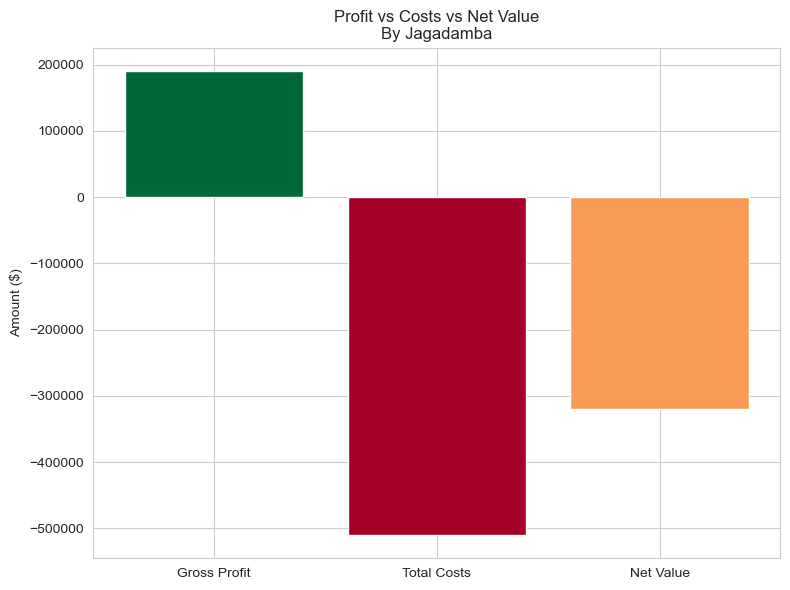

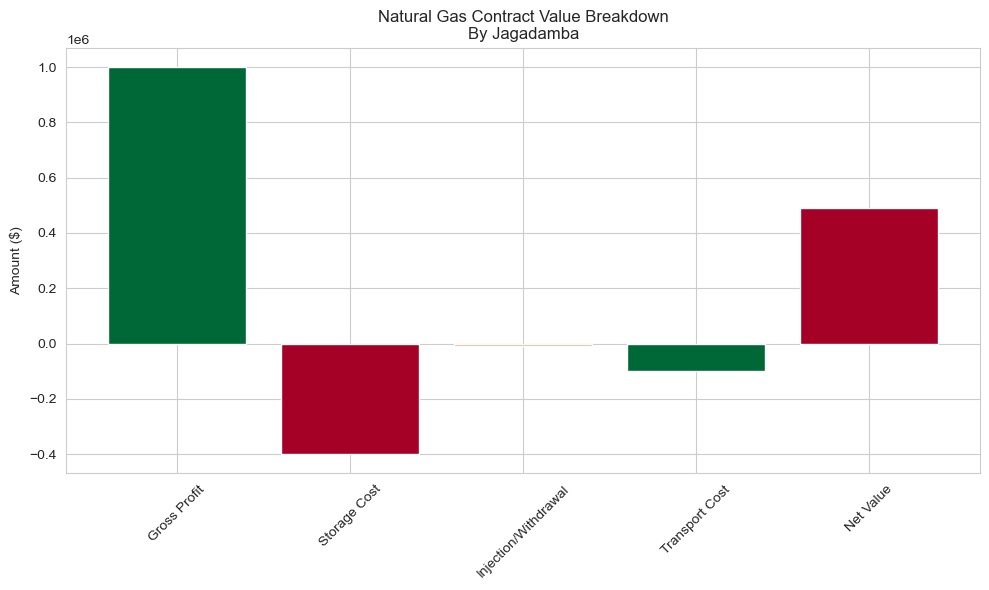

In [16]:
# ------------------------------------------------------------
# 12. BAR CHART → Profit vs Costs vs Net Value
# ------------------------------------------------------------

components = ["Gross Profit", "Total Costs", "Net Value"]
values = [expected_gross_profit, -total_costs, expected_net_value]

norm = plt.Normalize(min(values), max(values))
colors = plt.cm.RdYlGn(norm(values))

plt.figure(figsize=(8,6))
plt.bar(components, values, color=colors)
plt.title("Profit vs Costs vs Net Value\nBy Jagadamba")
plt.ylabel("Amount ($)")
plt.tight_layout()
plt.show()

# -------------------------------
# 13. BAR PLOT
# -------------------------------

plt.figure(figsize=(10,6))
bars = plt.bar(data["Component"], data["Amount"], color=colors)
plt.title("Natural Gas Contract Value Breakdown\nBy Jagadamba")
plt.ylabel("Amount ($)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

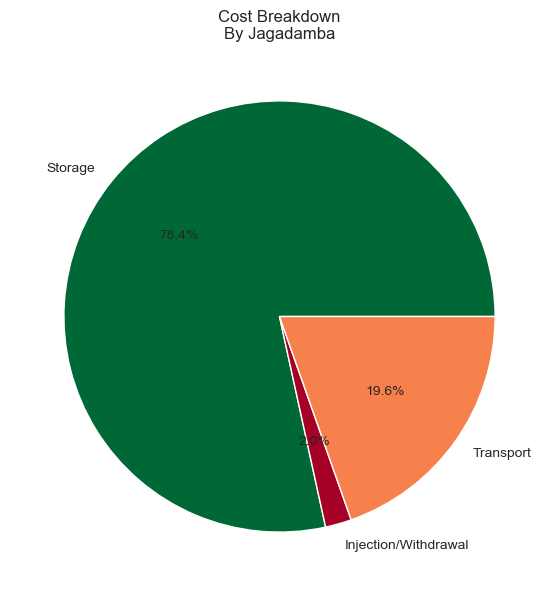

In [17]:
# ------------------------------------------------------------
# 14. PIE CHART → Cost Breakdown
# ------------------------------------------------------------

cost_labels = ["Storage", "Injection/Withdrawal", "Transport"]
cost_values = [storage_total, injection_withdrawal_cost, transport_cost]

norm_cost = plt.Normalize(min(cost_values), max(cost_values))
colors_cost = plt.cm.RdYlGn(norm_cost(cost_values))

plt.figure(figsize=(7,7))
plt.pie(cost_values,
        labels=cost_labels,
        autopct="%1.1f%%",
        colors=colors_cost)
plt.title("Cost Breakdown\nBy Jagadamba")
plt.show()



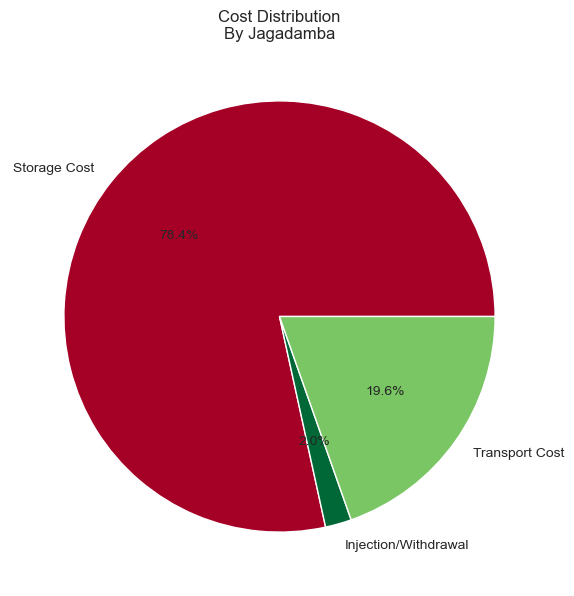

In [18]:
# -------------------------------
# 15. PIE CHART (Cost Distribution Only)
# -------------------------------

cost_data = data[data["Amount"] < 0]

norm_cost = plt.Normalize(cost_data["Amount"].min(), cost_data["Amount"].max())
colors_cost = plt.cm.RdYlGn(norm_cost(cost_data["Amount"]))

plt.figure(figsize=(7,7))
plt.pie(
    abs(cost_data["Amount"]),
    labels=cost_data["Component"],
    autopct="%1.1f%%",
    colors=colors_cost
)
plt.title("Cost Distribution\nBy Jagadamba")
plt.show()


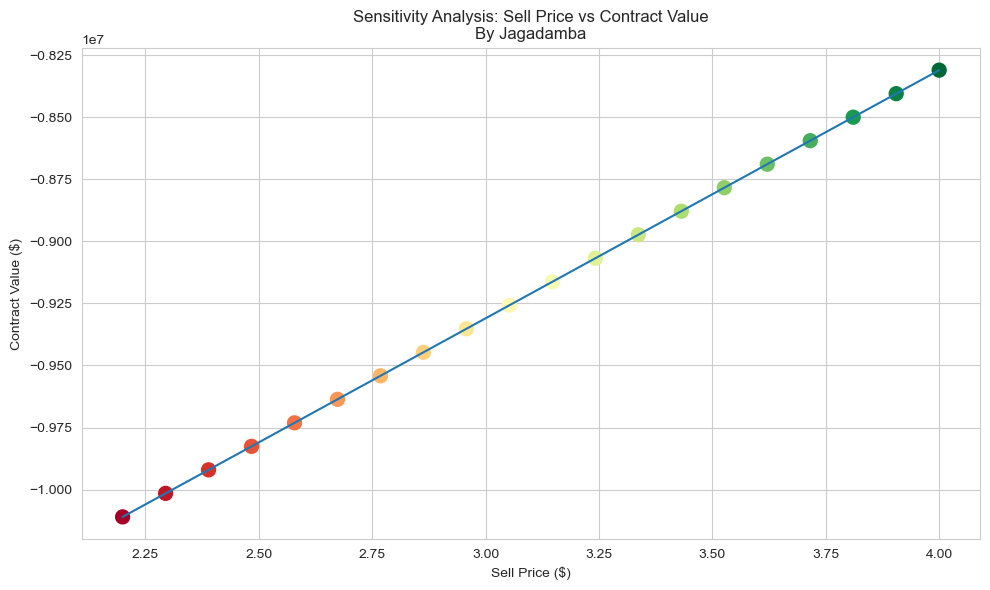

In [19]:
# -------------------------------
# 16. SENSITIVITY ANALYSIS (Sell Price Change)
# -------------------------------

sell_prices = np.linspace(2.2, 4.0, 20)
values = []

for sp in sell_prices:
    gross = (sp - buy_price) * quantity
    net = gross - total_costs
    values.append(net)

sensitivity_df = pd.DataFrame({
    "Sell Price": sell_prices,
    "Contract Value": values
})

norm2 = plt.Normalize(min(values), max(values))
colors2 = plt.cm.RdYlGn(norm2(values))

plt.figure(figsize=(10,6))
plt.scatter(sell_prices, values, c=colors2, s=100)
plt.plot(sell_prices, values)
plt.title("Sensitivity Analysis: Sell Price vs Contract Value\nBy Jagadamba")
plt.xlabel("Sell Price ($)")
plt.ylabel("Contract Value ($)")
plt.tight_layout()
plt.show()

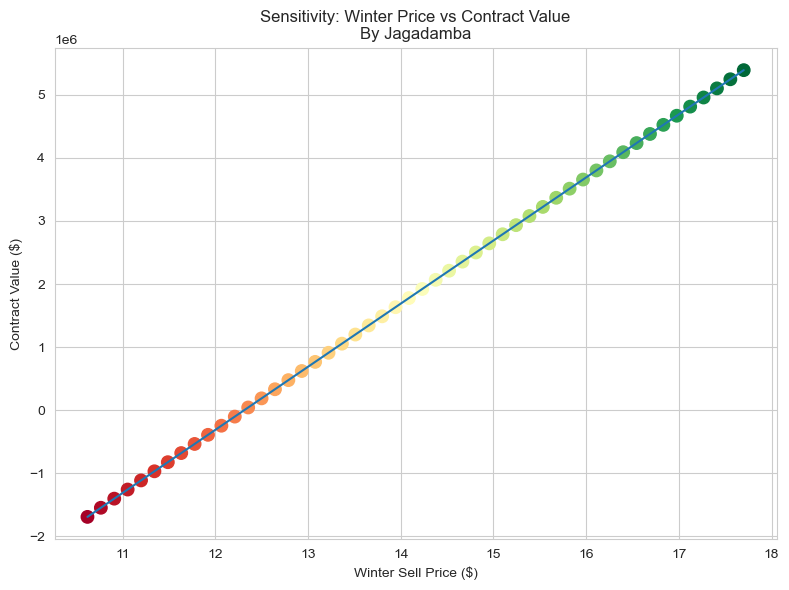

In [20]:
# ------------------------------------------------------------
# 17. SENSITIVITY CHART → Winter Price vs Contract Value
# ------------------------------------------------------------

sell_prices_range = np.linspace(buy_price * 0.9, buy_price * 1.5, 50)
sensitivity_values = (sell_prices_range - buy_price) * quantity - total_costs

norm2 = plt.Normalize(min(sensitivity_values), max(sensitivity_values))
colors2 = plt.cm.RdYlGn(norm2(sensitivity_values))

plt.figure(figsize=(8,6))
plt.scatter(sell_prices_range, sensitivity_values, c=colors2, s=80)
plt.plot(sell_prices_range, sensitivity_values)
plt.title("Sensitivity: Winter Price vs Contract Value\nBy Jagadamba")
plt.xlabel("Winter Sell Price ($)")
plt.ylabel("Contract Value ($)")
plt.tight_layout()
plt.show()

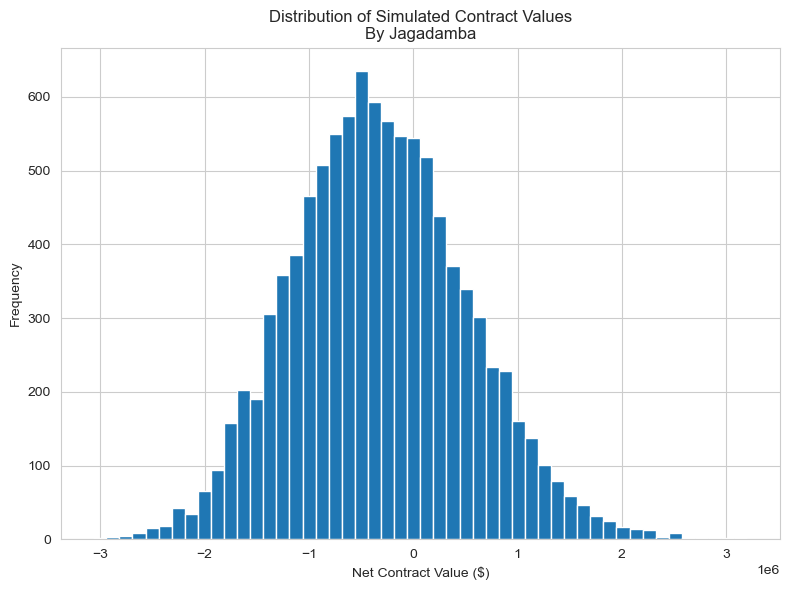

In [21]:
# ------------------------------------------------------------
# 18. DISTRIBUTION OF NET VALUES (Monte Carlo Result)
# ------------------------------------------------------------

norm3 = plt.Normalize(min(net_values), max(net_values))
colors3 = plt.cm.RdYlGn(norm3(net_values))

plt.figure(figsize=(8,6))
plt.hist(net_values, bins=50)
plt.title("Distribution of Simulated Contract Values\nBy Jagadamba")
plt.xlabel("Net Contract Value ($)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

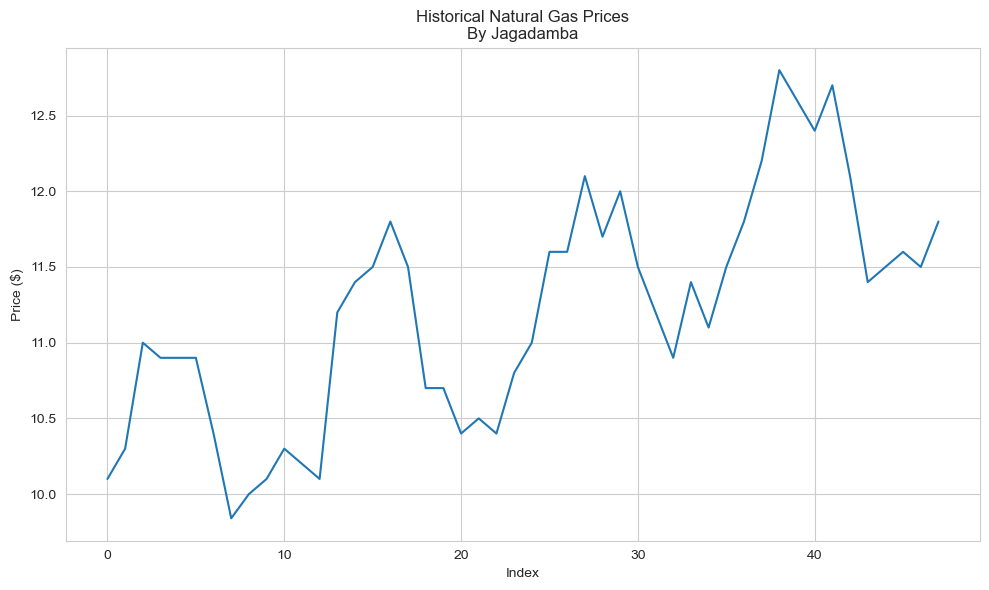

In [24]:
# ------------------------------------------------------------
# 19. DATASET MATCHING GRAPH (Historical Price Trend)
# ------------------------------------------------------------

plt.figure(figsize=(10,6))
sns.lineplot(data=df, x=df.index, y="Prices")
plt.title("Historical Natural Gas Prices\nBy Jagadamba")
plt.xlabel("Index")
plt.ylabel("Price ($)")
plt.tight_layout()
plt.show()

In [26]:
# ------------------------------------------------------------
# 20. RETURNS CALCULATION
# ------------------------------------------------------------

df["Returns"] = df["Prices"].pct_change()
returns = df["Returns"].dropna()

mu = returns.mean()
sigma = returns.std()

current_price = df["Prices"].iloc[-1]

In [27]:
# ------------------------------------------------------------
# 21. COST STRUCTURE by MONTHS
# ------------------------------------------------------------

storage_cost = 100_000 * months
inj_cost = 10_000
transport_cost = 50_000 * 2
total_costs = storage_cost + inj_cost + transport_cost

gross_profits = (simulated_prices - current_price) * quantity
net_values = gross_profits - total_costs

In [28]:
# ------------------------------------------------------------
# 22. RISK METRICS
# ------------------------------------------------------------

expected_net = np.mean(net_values)

# 95% Value-at-Risk (5th percentile)
var_95 = np.percentile(net_values, 5)

# Probability of Loss
prob_loss = np.mean(net_values < 0) * 100

print("========== RISK METRICS ==========")
print(f"Expected Net Contract Value: ${expected_net:,.0f}")
print(f"95% Value-at-Risk (VaR): ${var_95:,.0f}")
print(f"Probability of Loss: {prob_loss:.2f}%")

========== RISK METRICS ==========
Expected Net Contract Value: $-319,335
95% Value-at-Risk (VaR): $-1,653,626
Probability of Loss: 65.80%


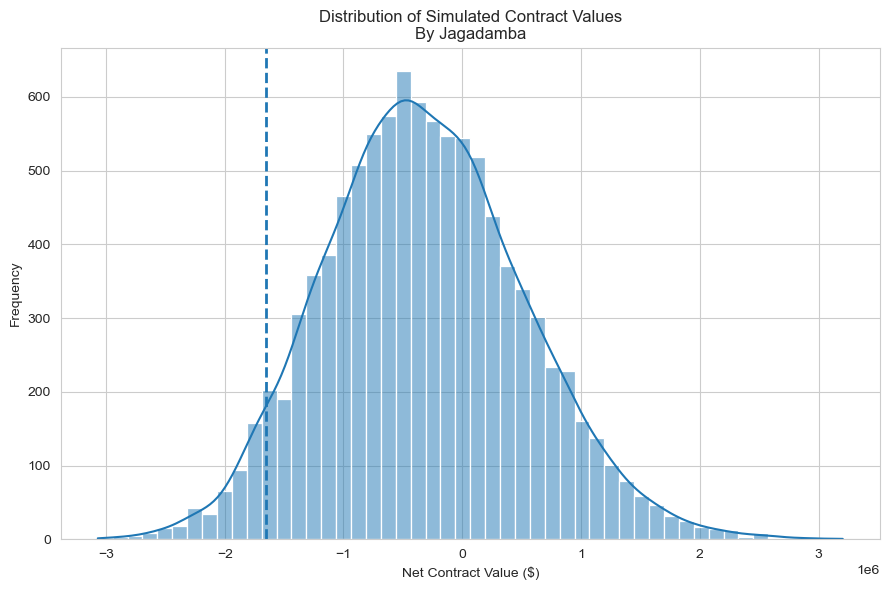

In [29]:
# ------------------------------------------------------------
# 23. DISTRIBUTION WITH VaR LINE
# ------------------------------------------------------------

plt.figure(figsize=(9,6))
sns.histplot(net_values, bins=50, kde=True)

plt.axvline(var_95, linestyle="--", linewidth=2)
plt.title("Distribution of Simulated Contract Values\nBy Jagadamba")
plt.xlabel("Net Contract Value ($)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()